In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow


from __future__ import print_function
import os
import tensorflow
from concurrent.futures import ThreadPoolExecutor
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import os,sys,glob
import pandas as pd

import matplotlib


from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard


from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense,Embedding,Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,accuracy_score, confusion_matrix
# from custom_dataloader.dataloader import ti_image_generator
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.keras import TqdmCallback
import scipy.io as sio

from concurrent.futures import ThreadPoolExecutor


In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [ ]:
# matplotlib global parameters

matplotlib.rcParams.update({'font.size': 14})
# Say, "the default sans-serif font is COMIC SANS"
# matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [ ]:
import bisect
import warnings

class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __init__(self, dtype='float32'):
        self.dtype = dtype

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

class ConcatDataset(Dataset):
    """
    Dataset to concatenate multiple datasets.
    Purpose: useful to assemble different existing datasets, possibly
    large-scale datasets as the concatenation operation is done in an
    on-the-fly manner.

    Arguments:
        datasets (sequence): List of datasets to be concatenated
    """

    @staticmethod
    def cumsum(sequence):
        r, s = [], 0
        for e in sequence:
            l = len(e)
            r.append(l + s)
            s += l
        return r

    def __init__(self, datasets):
        super(ConcatDataset, self).__init__()
        assert len(datasets) > 0, 'datasets should not be an empty iterable'
        self.datasets = list(datasets)
        self.cumulative_sizes = self.cumsum(self.datasets)

    def __len__(self):
        return self.cumulative_sizes[-1]

    def __getitem__(self, idx):
        dataset_idx = bisect.bisect_right(self.cumulative_sizes, idx)
        if dataset_idx == 0:
            sample_idx = idx
        else:
            sample_idx = idx - self.cumulative_sizes[dataset_idx - 1]
        return self.datasets[dataset_idx][sample_idx]

    @property
    def cummulative_sizes(self):
        warnings.warn("cummulative_sizes attribute is renamed to "
                      "cumulative_sizes", DeprecationWarning, stacklevel=2)
        return self.cumulative_sizes

In [ ]:
def default_collate_fn(samples):
    X = np.array([sample['x'] for sample in samples])
    Y = np.array([sample['y'] for sample in samples])

    return X, Y

class ti_image_generator(keras.utils.Sequence):
    def __init__(self,
                 dataset=Dataset,
                 collate_fn=default_collate_fn,
                 batch_size=32,
                 shuffle=True,
                 num_workers=0,
                 replacement=False,
                 ):
        """
        :param dataset (Dataset): Data set to load
        :param batch_size (int): how many samples in one batch
        :param shuffle (bool, optional): set to ``True`` to have the data reshuffled
            at every epoch (default: ``True``).
        :param num_workers (int, optional): how many threads to use for data
            loading in one batch. 0 means that the data will be loaded in the main process.
            (default: ``0``)
        :param replacement (bool): samples are drawn with replacement if ``True``, default=False
        :param collate_fn (callable, optional):
        """
        self.dataset = dataset
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.replacement = replacement
        self.indices = []
        self.collate_fn = collate_fn
        self.on_epoch_end()

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size: (index + 1) * self.batch_size]

        samples = []
        if self.num_workers == 0:
            for i in indices:
                data = self.dataset[i]
                samples.append(data)
        else:
            with ThreadPoolExecutor(max_workers=self.num_workers) as executor:
                for sample in executor.map(lambda i: self.dataset[i], indices):
                    samples.append(sample)
        X, Y = self.collate_fn(samples)
        return X, Y

    def on_epoch_end(self):
        n = len(self.dataset)
        seq = np.arange(0, n)
        if self.shuffle:
            if self.replacement:
                self.indices = np.random.randint(low=0, high=n, size=(n,),
                                                 dtype=np.int64).tolist()
            else:
                np.random.shuffle(seq)
                self.indices = seq
        else:
            self.indices = seq

    def __len__(self):
        return int(np.floor(len(self.dataset) / self.batch_size))



In [ ]:
# training params
learning_rate = 0.001 #0.001
batch_size = 25 #128

Train = True
# Train = False

patchsize = 25

hidden = 20
resize = 7 #11
epochs = 3 #5

csvfilepath = "/content/drive/MyDrive/training_data/"
# hidden = 20
# resize = 11


csvinputlen = patchsize * patchsize
networkinputlen = resize * resize
middle = int(csvinputlen / 2)

tau = 100000 # 300ms if use exp decay for preprocessing

prefix = 'aMSEO1H' + str(hidden) + '_linear_' + str(resize)
print("test")

test


In [ ]:
def plot_confusion_matrix(cm, savename, title='Confusion Matrix'):
    plt.figure(figsize=(12, 8), dpi=100)
    np.set_printoptions(precision=2)

    classes = ['Not Fall', 'Fall']
    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=15, va='center', ha='center')

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')

    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)

    # show confusion matrix
    plt.savefig(savename, format='png')
    plt.show()


In [ ]:
# LossHistory, keep loss and acc
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_accuracy'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_accuracy'))

    def loss_plot(self, loss_type):
        global prefix
        global tempfilename
        iters = range(len(self.losses[loss_type]))
        np.save( prefix + 'acc.npy', np.array(self.accuracy[loss_type]))
        np.save( prefix + 'loss.npy', np.array(self.losses[loss_type]))

        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")

        plt.savefig(prefix + 'training.pdf')

        # plt.savefig("imdb_keras.pdf")
        # plt.show()

In [ ]:
def preprocessingresize(features, resize,targetEventTS):
    features = features.transpose()
    # normalization
    featuresdiff = features - targetEventTS # features[middle]
    featuresNormed = (tau - np.abs(featuresdiff)) * 1.0 / tau
    featuresNormed = np.clip(featuresNormed, 0, 1)
    # featuresNormed = np.exp(-np.abs(featuresdiff)/tau)

    featuresNormed = featuresNormed.transpose()

    # crop
    features = featuresNormed.reshape(patchsize, patchsize)
    margin = int((patchsize - resize) / 2)
    cropend = patchsize - margin
    features = features[margin:cropend, margin:cropend]
    features = features.reshape(resize * resize)
    # print(featuresNormed.shape)
    return features

In [ ]:
def preprocessing(features, targetEventTS):
    middle = int(patchsize * patchsize / 2)
    features = features.transpose()
    # normalization
    featuresdiff = features - targetEventTS
    featuresNormed = (tau - np.abs(featuresdiff)) * 1.0 / tau
    featuresNormed = np.clip(featuresNormed, 0, 1)
    # featuresNormed = np.exp(-np.abs(featuresdiff)/tau)

    featuresNormed = featuresNormed.transpose()
    return featuresNormed

In [ ]:
class MyDataset():
    def __init__(self, frame, transform=None):
        self.data_frame = frame
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        m_data = self.data_frame.iloc[idx, :].values
        m_data = m_data.astype('float')

        if patchsize > resize:
            sample = {'y': m_data[1], 'x': preprocessingresize(m_data[2:2+csvinputlen], resize, m_data[0])}
        else:
            sample = {'y': m_data[1], 'x': preprocessing(m_data[2:2+csvinputlen], m_data[0])}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:

def splittraintest(csvdir, splitratio):
    allFiles = glob.glob(os.path.join(csvdir,'*TI25*.csv'))
    print(len(allFiles))
    if len(allFiles) > 0:
        np_array_list = []
        for file_ in allFiles:
            print(file_)
            #df = np.loadtext(file_,usecols=[i for i in range(2,4+csvinputlen)])
            df = pd.read_csv(file_,usecols=[i for i in range(2,4+csvinputlen)], header=0)
            # if np.any(np.isnan(pd.DataFrame(df))):
            #     print('!!!!!!!!!!!!!!!!!!!!!!!there is nan')
            #     exit(0)
            # print(df.size)
            np_array_list.append(df.values)



        # read all csv files in a folder to one pandas frame
        comb_np_array = np.vstack(np_array_list)
        np.random.shuffle(comb_np_array)
        big_frame = pd.DataFrame(comb_np_array)
        big_frame = big_frame.fillna(0)
        print(big_frame.head(), big_frame.size)



        #big_frame = big_frame.sample(frac=1)
        #print('shuffle done')

        if np.any(np.isnan(big_frame)):
          print('!!!!!!!!!!!!!!!!!!!!!!!there is nan')
          exit(0)

        # msk = np.random.rand(len(big_frame)) > splitratio
        # print('mask done')
        # trainset = big_frame[msk]
        # testset = big_frame[~msk]

        # split train and test set
        leng = len(big_frame)
        trainset = big_frame.iloc[:int(splitratio*leng)]
        testset = big_frame.iloc[int(splitratio*leng):]
        del big_frame
        # del msk
        return trainset, testset

In [ ]:
Train = True

In [ ]:
train = {}
val = {}

traindata, testdata = splittraintest(csvdir=csvfilepath, splitratio=0.8)

trainset = MyDataset(traindata)
testset = MyDataset(testdata)

# datagenerator = DataGenerator(dataset, batch_size=batch_size, shuffle=True)
traingenerator = ti_image_generator(trainset, batch_size=batch_size, shuffle=True)
testgenerator = ti_image_generator(testset, batch_size=batch_size, shuffle=True)



5
/content/drive/MyDrive/training_data/mixedhotellightTI25.csv
/content/drive/MyDrive/training_data/mixeddrishot5long3TI25.csv
/content/drive/MyDrive/training_data/mixeddrishot5long1TI25.csv
/content/drive/MyDrive/training_data/mixeddrishot5long2TI25.csv
/content/drive/MyDrive/training_data/mixeddot1lightTI25.csv
   0        1    2         3           4           5           6    \
0  132   722607    0    699661  1611974467  1611962560  1611973685   
1  247   699850    0   3319395   178947710    52814832           0   
2   99  2127771    1   2052459           0           0           0   
3  151  2116976    1         0           0           0           0   
4   20   726382    0  53046859      720047   179025535     3324793   

          7           8          9    ...        617      618       619  \
0  1611932463  1611888122     698562  ...  178887182        0         0   
1   178880158    53086541  179007714  ...    3303503   699586  52887584   
2           0     2048809    2057378  .

In [ ]:
if Train:
    inputs = Input(shape=(networkinputlen, ), name='input')
    x = Dense(hidden,  activation='relu', name='fc1')(inputs) #input_shape=(networkinputlen, ),
    #x = Dense(hidden, activation='relu', name='fc2')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=1, activation='sigmoid', name='output')(x)
    model = Model(inputs, x)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 49)]              0         
                                                                 
 fc1 (Dense)                 (None, 20)                1000      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 output (Dense)              (None, 1)                 21        
                                                                 
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(len(traingenerator))
print(traingenerator[0])
print(traingenerator[1])
print(traingenerator[1][0])
print(traingenerator[1][0][24][24])
#list(traingenerator[1][0][i][24] for i in range(len(traingenerator[1][0])))

#y_true = np.concatenate([traingenerator[i][0][24][24] for i in range(len(traingenerator))])
#print(y_true)
#print(len(y_true))


5657
(array([[0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.99953, 0.99953, 0.99953, ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.9997 , 0.9997 , 0.     ],
       ...,
       [0.     , 0.     , 0.     , ..., 0.99863, 0.99863, 0.99863],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.9984 , ..., 0.9984 , 0.9984 , 0.9984 ]]), array([7.50137000e+05, 5.30814400e+06, 1.60742798e+09, 5.68618500e+06,
       2.06805400e+06, 2.08902200e+06, 5.79304700e+06, 2.04671000e+06,
       1.60887454e+09, 5.39167200e+06, 2.07567400e+06, 2.12872300e+06,
       2.09441400e+06, 2.07265300e+06, 2.07629600e+06, 5.91102800e+06,
       3.99616800e+06, 7.34122000e+05, 4.97703900e+06, 2.07269800e+06,
       3.91260800e+06, 1.60746130e+09, 2.06360900e+06, 2.08419200e+06,
       7.41983000e+05, 1.60872833e+09, 3.89531900e+06, 7.40941000e+05,
       1.60876208e+09, 2.06330800e+06, 3.93688300e+06, 2.09518700e+06,
    

In [ ]:
# Execute Main Block

print(len(traingenerator))
print(len(testgenerator))

if Train:
    print('Build model...')

    #inputs = Input(shape=[networkinputlen, ], name='input')
    #x = Dense(hidden, input_shape=(networkinputlen, ), activation='relu', name='fc1')(inputs) #
    ## x = Dense(hidden, activation='relu', name='fc2')(x)
    #x = Dropout(0.2)(x)
    #x = Dense(1, activation='sigmoid', name='output')(x)
    # # x = Dense(2, activation='softmax', name='output')(x)
    #model = Model(inputs, x)

    optimizer = Adam(learning_rate=0.001)
    #optimizer = SGD(lr=0.00001,decay=1e-6,momentum=0.9,nesterov=True)

    #model.compile(optimizer, loss='mse',metrics='accuracy')#metrics=['accuracy']   metrics=[tensorflow.keras.metrics.Accuracy()]
    #model.compile(optimizer, loss='mse',metrics=[tensorflow.keras.metrics.MeanSquaredError()])#metrics=['accuracy']   metrics=[tensorflow.keras.metrics.Accuracy()]
    model.compile(optimizer, loss='mean_squared_error', metrics=[tensorflow.keras.metrics.Accuracy()])#metrics=['accuracy']
    #model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=[tensorflow.keras.metrics.BinaryAccuracy()])

    #original
    #model.compile(optimizer, loss='mean_squared_error',metrics=['accuracy'])
    #model.compile(optimizer, loss='loss='binary_crossentropy',metrics=['accuracy'])
    #model.compile(optimizer, loss='categorical_crossentropy',metrics=['accuracy']) # for 2 output

    history = LossHistory()

    filepath="aweightsI"+str(resize) + 'H' + str(hidden) + "-{epoch:02d}-{val_accuracy:.3f}.h5"
    #checkpoint = ModelCheckpoint(filepath,monitor='val_accuracy',mode='max' ,save_best_only='True',period=10)
    #aa = np.concatenate([traingenerator[i][0][24] for i in range(len(traingenerator))])
    #print(np.count_nonzero(aa),len(aa))
    #bb = [traingenerator[i][0] for i in range(len(traingenerator))]
    #bb=[bb[i][0] for i in range(len(traingenerator))]
    #bb=[bb[i] for i in range(49)]
    #print(len(bb))
    model.fit(traingenerator,epochs=3, validation_data=testgenerator, verbose=2, workers=1,use_multiprocessing=False,batch_size=batch_size)#callbacks=[history,checkpoint],
    model.summary(show_trainable=True)
    #history.loss_plot('epoch')

    model.save( prefix + '.h5')
else:
    model = load_model( prefix + '.h5')
    model.summary()

#model.save('/content/drive/MyDrive/training data/model')

5657
1414
Build model...
Epoch 1/3
5657/5657 - 77s - loss: 594248239100723200.0000 - accuracy: 0.0000e+00 - val_loss: 601152141331005440.0000 - val_accuracy: 0.0000e+00 - 77s/epoch - 14ms/step
Epoch 2/3
5657/5657 - 76s - loss: 594257791107989504.0000 - accuracy: 0.0000e+00 - val_loss: 601041365534507008.0000 - val_accuracy: 0.0000e+00 - 76s/epoch - 13ms/step
Epoch 3/3
5657/5657 - 75s - loss: 594257103913222144.0000 - accuracy: 0.0000e+00 - val_loss: 601040747059216384.0000 - val_accuracy: 0.0000e+00 - 75s/epoch - 13ms/step
Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input (InputLayer)          [(None, 49)]              0         Y          
                                                                            
 fc1 (Dense)                 (None, 20)                1000      Y          
                                                                     

1414
49
49
49
(array([[0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.99971, 0.99971, 0.99971, ..., 0.     , 0.     , 0.     ],
       ...,
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.99846]]), array([3.91680600e+06, 1.61104617e+09, 2.13266900e+06, 5.92910200e+06,
       5.40897100e+06, 2.12666400e+06, 1.61110094e+09, 3.98137100e+06,
       5.37984900e+06, 1.60740123e+09, 1.60894069e+09, 2.04410600e+06,
       2.12726300e+06, 2.05164300e+06, 2.07447700e+06, 7.21251000e+05,
       1.61103083e+09, 2.06260200e+06, 3.98690500e+06, 4.93022100e+06,
       3.98807200e+06, 2.05260800e+06, 1.60871875e+09, 7.28404000e+05,
       7.54235000e+05, 5.99684300e+06, 1.61099260e+09, 3.97747700e+06,
       3.99679500e+06, 2.04137700e+06, 3.99757000e+06, 3.95428800e

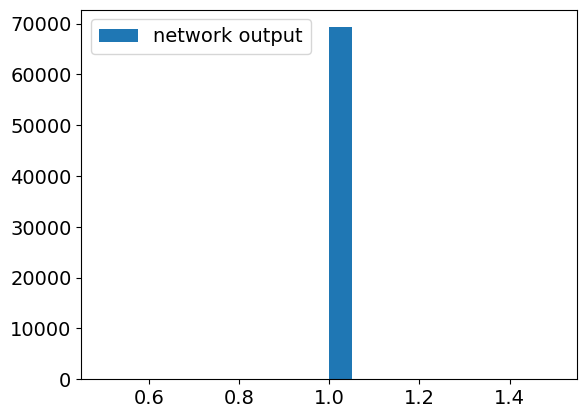

In [ ]:
n_batches = len(testgenerator)
print(n_batches)
print(len(testgenerator[0][0]))
print(len(testgenerator[0][0][0]))
print(len(testgenerator[0][1]))
print(testgenerator[0])



y_true = np.concatenate([testgenerator[i][0][24] for i in range(n_batches)])
#y_true = np.concatenate([testgenerator[i][1] for i in range(n_batches)])



initpredictions = model.predict(testgenerator, steps=n_batches)
print(initpredictions)

y_pred = (initpredictions > 0.5).astype(int)
y_true = np.ceil(np.reshape(y_true, [-1]))



y_pred = np.reshape(y_pred, [-1])
print(y_true.shape, y_pred.shape)
print(y_true, y_pred)
print(np.count_nonzero(y_true),np.count_nonzero(y_pred))
finderrorloc = y_true == y_pred
indices = np.where(finderrorloc == False)

accuracy = accuracy_score(y_true, y_pred)
print(accuracy)
#precision = precision_score(y_true, y_pred)
TPR = recall_score(y_true, y_pred, average=None)
print('TPR:',TPR)
f1score = f1_score(y_true, y_pred, average=None)
print('f1score:',f1score)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print(tn,"  ", fp,"  ", fn,"  ", tp)
print(confusion_matrix(y_true, y_pred).ravel())
specificity = tn * 1.0 / (tn + fp) # TNR
FPR = fp * 1.0 / (tn + fp)
print('FPR:',FPR)
#print( prefix + '.h5')
print('testacc:',accuracy)
#print('precision:',precision)



cm= confusion_matrix(y_true, y_pred)

print(cm)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)

# plot output distribution
initpredictions = np.array(initpredictions)
initpredictions = initpredictions.reshape((initpredictions.shape[0] * initpredictions.shape[1]))
plt.clf()
plt.hist(initpredictions, bins=20, label='network output')
plt.legend()
plt.savefig(prefix + 'outputhist.pdf')